In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## load data

In [2]:
%%time
ds = xr.open_dataset("/glade/scratch/zhonghua/b.e21.BHISTcmip6.f09_g17.LE2-1231.003.clm2.h6.TREFMXAV.19900101-19991231.nc")

CPU times: user 60.3 ms, sys: 19.9 ms, total: 80.2 ms
Wall time: 80.3 ms


## get 2d location and rounded 2d location

In [3]:
# get 2d location and rounded 2d location
lat_ls = []
lon_ls = []
for lon in ds.lon.values:
    for lat in ds.lat.values:
        lon_ls.append(lon)
        lat_ls.append(lat)
df_loc = pd.DataFrame({"lat":lat_ls,"lon":lon_ls})
df_loc["lat_r"] = df_loc["lat"].round(2)
df_loc["lon_r"] = df_loc["lon"].round(2)

## set up the conditions for placeholders  
We want to have "land1d_active==1" and "land1d_wtgcell">0"

In [4]:
## set up the conditions for placeholders
print(ds["land1d_ityplunit"],"\n")
print("###############")
print(ds["land1d_active"],"\n")
print(ds["land1d_ityplunit"].where(ds["land1d_active"]),"\n")
print("###############")
print(ds["land1d_wtgcell"],"\n")
print(ds["land1d_ityplunit"].where(ds["land1d_active"]).where(ds["land1d_wtgcell"]>0),"\n")

<xarray.DataArray 'land1d_ityplunit' (landunit: 62125)>
array([1., 2., 4., ..., 2., 6., 4.])
Dimensions without coordinates: landunit
Attributes:
    long_name:  landunit type (vegetated,urban,lake,wetland,glacier or glacie... 

###############
<xarray.DataArray 'land1d_active' (landunit: 62125)>
array([1., 0., 1., ..., 0., 1., 1.])
Dimensions without coordinates: landunit
Attributes:
    long_name:      true => do computations on this landunit
    flag_values:    [0 1]
    flag_meanings:  FALSE TRUE
    valid_range:    [0 1] 

<xarray.DataArray 'land1d_ityplunit' (landunit: 62125)>
array([ 1., nan,  4., ..., nan,  6.,  4.])
Dimensions without coordinates: landunit
Attributes:
    long_name:  landunit type (vegetated,urban,lake,wetland,glacier or glacie... 

###############
<xarray.DataArray 'land1d_wtgcell' (landunit: 62125)>
array([0., 0., 1., ..., 0., 1., 0.])
Dimensions without coordinates: landunit
Attributes:
    long_name:  landunit weight relative to corresponding gridcell 

<x

In [5]:
def get_var_1d(ds, var, land1d_ityplunit):
    """This function returns the xarray.Dataset 
    with variables var, lat, lon

    Parameters
    ----------
    ds : xarray.Dataset
        raw dataset 
    var : str
        a variable that we are interested in
        e.g., "TREFMXAV"
    land1d_ityplunit : int
        urban landunits  
        e.g., 7, 8 - see the global attributes

    Returns
    -------
    xarray.Dataset
        xarray dataset with dimension [landunit, time]
    """
    
    # get land1d_ityplunit with "land1d_active==1" and "land1d_wtgcell>0"
    active_lnd = ds["land1d_ityplunit"].where(ds["land1d_active"]).where(ds["land1d_wtgcell"]>0)
    
    # select the land1d_ityplunit: urban landunits (which are 7, 8, and 9 - see the global attributes)
    idx = (active_lnd.values == land1d_ityplunit)
    
    # get var, land1d_lat, and land1d_lat datasets
    ds_var = ds[var][:,idx]

    lat = ds.land1d_lat[idx]\
    .expand_dims(time = ds_var.time)\
    .assign_coords(landunit=ds_var.landunit) # add the consistent time dimension

    lon = ds.land1d_lon[idx]\
    .expand_dims(time = ds_var.time)\
    .assign_coords(landunit=ds_var.landunit) # add the consistent time dimension
    
    # merge and return
    return  xr.merge([lat,lon,ds_var])

def get_var_2d(ds_var_1d, ts=ds.time[0],var="TREFMXAV",df_loc=df_loc):
    """This function returns the xarray.Dataset 
    with dimension [lat, lon, time]

    Parameters
    ----------
    ds_var_1d : xarray.Dataset
        from the function "get_var_1d()"
    ts : 
        a single timestamp in the xarray.Dataset 
        e.g., ds.time[0]
    var : str
        a variable that we are interested in
        e.g., "TREFMXAV"
    df_loc : DataFrame
        # get 2d location and rounded 2d location
        lat_ls = []
        lon_ls = []
        for lon in ds.lon.values:
            for lat in ds.lat.values:
                lon_ls.append(lon)
                lat_ls.append(lat)
        df_loc = pd.DataFrame({"lat":lat_ls,"lon":lon_ls})
        df_loc["lat_r"] = df_loc["lat"].round(2)
        df_loc["lon_r"] = df_loc["lon"].round(2)

    Returns
    -------
    xarray.Dataset
        xarray dataset with dimension [lat, lon, time]
    """
    df = ds_var_1d.sel(time=ts).to_dataframe().reset_index()
    df["lat_r"] = df["land1d_lat"].round(2) 
    df["lon_r"] = df["land1d_lon"].round(2)
    
    ds_2d = pd.merge(df,df_loc,on=["lon_r","lat_r"],how="outer")[["lat","lon",var]]\
    .set_index(["lat","lon"]).to_xarray().assign_coords(time=ts).expand_dims('time')
    
    return ds_2d

shape of dataset: (3650, 144)


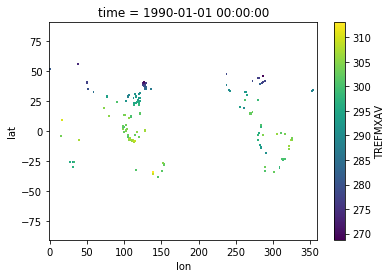

In [6]:
var = "TREFMXAV"
ds_var_1d = get_var_1d(ds, var, 7)
print("shape of dataset:",ds_var_1d[var].shape)

## select the first timestamp
ds_var_2d = get_var_2d(ds_var_1d, ts=ds.time[0])
ds_var_2d[var].plot()
plt.show()

## check the non-missing values

In [7]:
ds_var_2d.to_dataframe().dropna().shape

(144, 1)

## test for urban 8 and urban 9

shape of dataset: (3650, 3516)


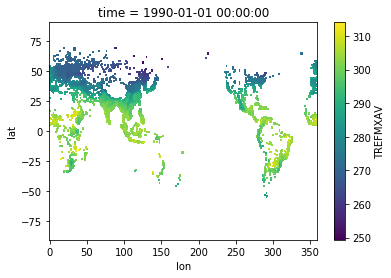

In [8]:
ds_var_1d = get_var_1d(ds, var, 8)
print("shape of dataset:",ds_var_1d[var].shape)

## select the first timestamp
ds_var_2d = get_var_2d(ds_var_1d, ts=ds.time[0])
ds_var_2d[var].plot()
plt.show()

shape of dataset: (3650, 4240)


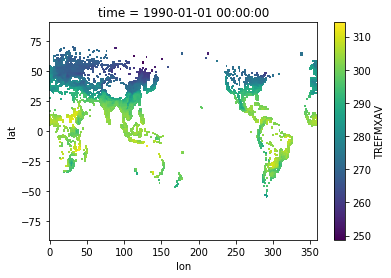

In [9]:
ds_var_1d = get_var_1d(ds, var, 9)
print("shape of dataset:",ds_var_1d[var].shape)

## select the first timestamp
ds_var_2d = get_var_2d(ds_var_1d, ts=ds.time[0])
ds_var_2d[var].plot()
plt.show()

## test the scalability

In [10]:
%%time 
ds_var_2d_ls = []
for ts in tqdm(ds["time"][1:100]):
#     pass
#     print(ts)
    ds_var_2d_ls.append(get_var_2d(ds_var_1d, ts=ts))

100%|██████████| 99/99 [01:06<00:00,  1.49it/s]

CPU times: user 1min 6s, sys: 146 ms, total: 1min 6s
Wall time: 1min 6s


In [11]:
xr.concat(ds_var_2d_ls,dim="time")

<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, time: 99)
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time      (time) object 1990-01-02 00:00:00 ... 1990-04-10 00:00:00
Data variables:
    TREFMXAV  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan